In [1]:
import pandas as pd
from matplotlib import pyplot
from math import sqrt 
import numpy as np 
import scipy.misc 
from IPython.display import display 
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
data= pd.read_csv('/content/drive/My Drive/Colab Notebooks/fer2013.csv')
data.head()

,Unnamed: 0,emotion,pixels,Usage
0,0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

print(data.emotion.value_counts())

num_classes = 6
width = 48
height = 48
emotion_labels = ["Angry", "Neutral", "Fear", "Happy", "Sad", "Surprise"]
classes=np.array(("Angry", "Neutral", "Fear", "Happy", "Sad", "Surprise"))

print(data.Usage.value_counts())

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64
Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64


In [3]:
data = data[data.emotion!=1]
data = data.replace({'emotion': {6:1}})
data.emotion.value_counts()

3    8989
1    6198
4    6077
2    5121
0    4953
5    4002
Name: emotion, dtype: int64

In [4]:
def cambiar(dataframe):
  contador = 0
  lista = []
  for i in dataframe:
    if(i==True and (contador < 3215)):
      lista.append(False)
      contador = contador +1
    else:
      lista.append(True)
  return lista

yes = data.emotion[(data.Usage == 'Training')]==3
generados = cambiar(yes)

In [5]:
# data.shape[0]*.7
train_set = data[(data.Usage == 'Training')]
train_set = train_set[generados]
val_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')] 
data = pd.concat([train_set, val_set,test_set])

## Distribución de los datos totales

In [6]:

data.emotion.value_counts()

1    6198
4    6077
3    5774
2    5121
0    4953
5    4002
Name: emotion, dtype: int64

## Distribución de los datos entrenamiento

In [9]:
trainData = data[:int(data.shape[0]*.7)]
trainData.emotion.value_counts()

1    4522
4    4385
2    3771
0    3600
3    3349
5    2860
Name: emotion, dtype: int64

## Distribución de los datos de entrenamiento y testeo

In [10]:
data_count = data.shape[0]
print('datos de entrenamienot:',str(int((data_count*.7*100)/data_count)),'% total:',str(int(data_count*.7)))
print('datos de testeo:',str(100-int((data_count*.7*100)/data_count)),'% total:',str(int(data_count-data_count*.7)))

datos de entrenamienot: 70 % total: 22487
datos de testeo: 30 % total: 9637


In [18]:
depth = 1
height = int(sqrt(len(data.pixels[0].split()))) 
width = int(height)
print(height,width)

train_set = data[:int(data.shape[0]*.7)]
val_set = data[int(data.shape[0]*.7):]
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32)
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)

num_train = X_train.shape[0]
num_val = X_val.shape[0]

y_train = train_set.emotion 
y_train = np_utils.to_categorical(y_train, num_classes) 
y_val = val_set.emotion 
y_val = np_utils.to_categorical(y_val, num_classes)

48 48


In [ ]:
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64

In [ ]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, y_val, batch_size=batch_size) 

In [ ]:
def FER_Model(input_shape=(48,48,1)):
    visible = Input(shape=input_shape, name='input')
    num_classes = 6
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.6, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.6, name = 'drop2_1')(pool2_1)

    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.6, name = 'drop3_1')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.6, name = 'drop4_1')(pool4_1)

    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.6, name = 'drop5_1')(pool5_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [ ]:
model = FER_Model()
# opt = Adam(lr=0.0001, decay=1e-6)
opt = SGD(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
pool1_1 (MaxPooling2D)       (None, 24, 24, 64)        0         
_________________________________________________________________
drop1_1 (Dropout)            (None, 24, 24, 64)       

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="weights_min_loss.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
num_epochs = 200
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size)
model.save('/content/drive/My Drive/Colab Notebooks/proyecto/model_filter_200EF.h5') 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200

Epoch 00001: val_loss improved from inf to 1.76536, saving model to weights_min_loss.hdf5
412/411 - 29s - loss: 2.8058 - accuracy: 0.2017 - val_loss: 1.7654 - val_accuracy: 0.1867
Epoch 2/200

Epoch 00002: val_loss did not improve from 1.76536
412/411 - 29s - loss: 1.7730 - accuracy: 0.2007 - val_loss: 1.7748 - val_accuracy: 0.1764
Epoch 3/200

Epoch 00003: val_loss improved from 1.76536 to 1.76409, saving model to weights_min_loss.hdf5
412/411 - 30s - loss: 1.7717 - accuracy: 0.2025 - val_loss: 1.7641 - val_accuracy: 0.1923
Epoch 4/200

Epoch 00004: val_loss did not improve from 1.76409
412/411 - 30s - loss: 1.7698 - accuracy: 0.2051 - val_loss: 1.7736 - val_accuracy: 0.1949
Epoch 5/200

Epoch 00005: val_loss improved from 1.76409 to 1.76112, saving model to weights_min_loss.hdf5
412/411 - 30s - loss: 1.7700 - accuracy: 0.2037 - val_loss: 1.7611 - val_accuracy: 0.1872
Epoch 6/200

Epoch 00006: val

## Resultados del entrenamiento

---
### resultados datos entrenamiento
### loss: 0.6288 - accuracy: 0.7658

---
### resultados datos testeo
### val_loss: 0.8136 - val_accuracy: 0.7223

## Gráficas de la perdida y del accuracy

<Figure size 432x288 with 0 Axes>

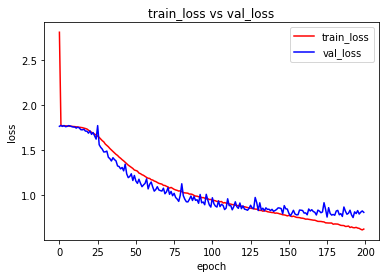

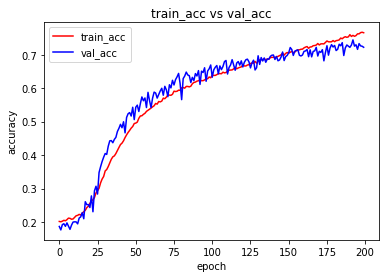

<Figure size 432x288 with 0 Axes>

In [ ]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

## Matriz de confusión de datos de testeo

In [13]:
#matriz de confucion
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    #normalizado
    cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
    label_mapdisgust = ["Angry", "Neutral", "Fear", "Happy", "Sad", "Surprise"]
    return pd.DataFrame(cm, index = label_mapdisgust,
                  columns = label_mapdisgust
                )

y_pred_ = model.predict(X_val/255.)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_val, axis=1)

fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred)

fig

,Angry,Neutral,Fear,Happy,Sad,Surprise
Angry,0.71,0.08,0.09,0.02,0.09,0.01
Neutral,0.07,0.74,0.05,0.02,0.11,0.01
Fear,0.09,0.09,0.60,0.01,0.14,0.06
Happy,0.02,0.09,0.02,0.82,0.02,0.02
Sad,0.11,0.16,0.11,0.01,0.60,0.01
Surprise,0.02,0.01,0.09,0.02,0.01,0.84


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


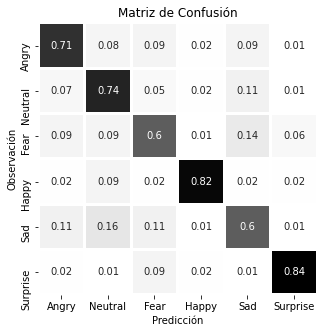

In [14]:
import seaborn as sns

plt.figure(figsize = (5,5))
sns.heatmap(fig, annot = True,cmap='Greys',cbar=False,linewidth=2)
plt.title('Matriz de Confusión')
plt.ylabel('Observación')
plt.xlabel('Predicción')
plt.show()



## Matriz de confusión de datos de entrenamiento

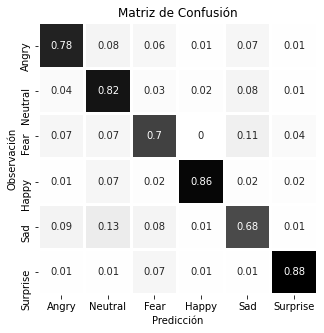

In [19]:
y_pred_ = model.predict(X_train/255.)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_train, axis=1)

fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred)

plt.figure(figsize = (5,5))
sns.heatmap(fig, annot = True,cmap='Greys',cbar=False,linewidth=2)
plt.title('Matriz de Confusión')
plt.ylabel('Observación')
plt.xlabel('Predicción')
plt.show()

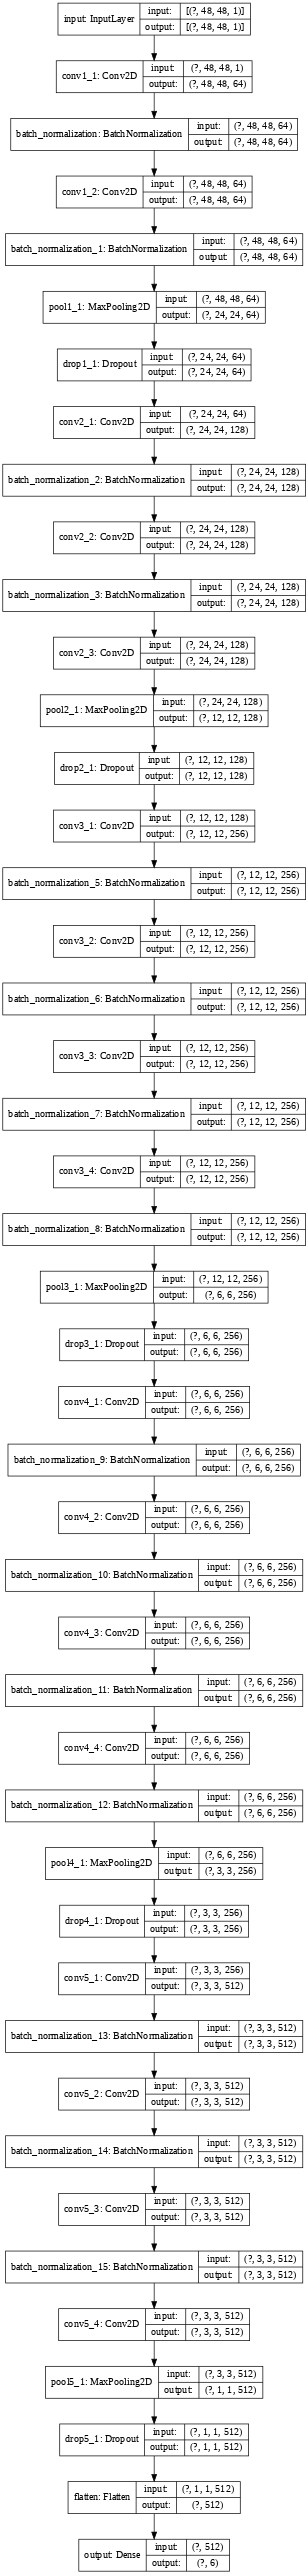

In [12]:
#resumen del modelo
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50)

In [12]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/Colab Notebooks/proyecto/model_filter_200EF.h5')